<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

В нашем распоряжении датасет, который мы должны изучить и подготовить к дальнейшей работе. 
Наши задачи:
1. Обучить несколько моделей (в нашем случае мы будем использовать модели решающего дерева, случайного леса и логистической регрессии) и оценить качество их предсказаний.
2. Обучить все те же самые модели, но с учетом дисбаланса классов. 
3. Выбрать лучшую модель и протестировать ее на тестовой выборке, предварительно проверив ее на адекватность. 
4. Посчитать метрику F-1 для лучшей модели. Она должна быть не меньше  0.59.
5. Написать общие выводы.

Цели очерчены, приступаем к предварительной обработке. Начнем с импортов.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv('/datasets/Churn.csv')

In [12]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В нашем датасете 10000 значений и 14 колонок. Проверим данные на дубликаты.

In [14]:
data.duplicated().sum()

0

Дубликаты не обнаружены. Теперь проверим отсутствующие значения.

In [15]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Очень много пропусков в столбце Tenure. Поскольку мы не хотим терять столько значений в датасете, эти пропущенные значения следует просто заменить. 

In [16]:
data['Tenure'] = data['Tenure'].fillna(1)

В датасете есть несколько столбцов с ненужной нам информацией (например, фамилия клиента или его ID). Поскольку мы решаем задачу классификации, такие данные будут мешать. Их следует либо заменить на цифры, придав каждому значению свой номер, либо удалить совсем. 

In [17]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

В столбце Geography встречаются значения только трех видов: 'France', 'Spain' и'Germany'. Поскольку их всего 3, каждому из этих значений можно дать свой порядковый номер. А вот столбцы 'RowNumber','CustomerId' и 'Surname' следует просто удалить.

In [18]:
data = data.drop(['RowNumber','CustomerId', 'Surname'], axis = 1)

In [19]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Столбцы Gender и Geography мы преобразуем с помощью OHE.

In [20]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


В новом датафрейме мы получили 12 столбцов.
Столбец Geography содержал 3 класса, Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

## Исследование задачи

Теперь наша задача - сформировать тестовую и обучающую выборки для наших моделей.

In [21]:
data_train, data_test = train_test_split(data_ohe, test_size=0.25, random_state=12345)

In [22]:
features_train = data_train.drop(['Exited'], axis = 1)
target_train = data_train['Exited']
features_test = data_test.drop(['Exited'], axis = 1)
target_test = data_test['Exited']

In [23]:
target_train.value_counts(normalize = 1)

0    0.799733
1    0.200267
Name: Exited, dtype: float64

Теперь мы знаем соотношение классов для нашей обучающей выборки. Самый частый класс (отрицательный) в ней занимает 0.799733 от всей выборки. Соответственно точность предсказаний нашей модели должна быть выше этого числа (иначе получится, что модель просто всегда предсказывает 0)

Выборки сформированы, приступаем к обучению моделей. Подбирать параметры моделей и обучать их мы будем при помощи GridSearchCV.

In [24]:
%%time

clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 15min 20s
Wall time: 40min 37s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [25]:
#сохраняем модель и смотрим параметры
forest_model = grid.best_estimator_

In [26]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 30}

In [27]:
accuracy_forest = grid.best_score_
print('Точность для модели случайного леса составляет', accuracy_forest) 

Точность для модели случайного леса составляет 0.8658666666666666


In [28]:
%%time

clf = DecisionTreeClassifier()
parametrs = { 'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 13.6 s
Wall time: 15.8 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2)})

In [29]:
tree_model = grid.best_estimator_

In [30]:
accuracy_tree = grid.best_score_
print('Точность для модели решающего дерева составляет', accuracy_tree) 

Точность для модели решающего дерева составляет 0.8550666666666666


In [31]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [32]:
%%time

#оставим пока только liblinear, а остальные солверы будем подбирать с учетом дисбаланса классов
#так обработка кода займет меньше времени

clf = LogisticRegression()
parametrs = {'max_iter': range (1,1001, 10),
            'solver': ['liblinear']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 34.2 s
Wall time: 18.1 s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': range(1, 1001, 10),
                         'solver': ['liblinear']})

In [33]:
log_model = grid.best_estimator_

In [34]:
grid.best_params_

{'max_iter': 1, 'solver': 'liblinear'}

In [35]:
accuracy_log = grid.best_score_ 
print('Точность для модели логистической регрессии составляет',accuracy_log)

Точность для модели логистической регрессии составляет 0.7997333333333334


Наши модели мы обучали на тренировочной выборке. Точность модели логистической регрессии точно совпала с долей отрицательного класса в датасете, что наталкивает на мысль о том, что модель просто спрогнозировала все ответы как нули. Остальные же модели дали значение точности выше.

## Борьба с дисбалансом

Посмотрим, что произойдет с предсказаниями моделей, если сбалансировать вес объектов в выборке, добавив аргумент class_weight='balanced'.

In [36]:
%%time

clf = RandomForestClassifier(random_state=12345, class_weight='balanced')
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 15min 33s
Wall time: 15min 39s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [37]:
forest_model_balanced = grid.best_estimator_

In [38]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [39]:
forest_model_balanced_accuracy = grid.best_score_ 
print('Точность для модели случайного леса с балансировкой классов составляет', forest_model_balanced_accuracy) 

Точность для модели случайного леса с балансировкой классов составляет 0.8375999999999999


In [40]:
%%time

clf = DecisionTreeClassifier(random_state = 12345, class_weight='balanced')
parametrs = { 'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'min_weight_fraction_leaf': range (0 ,10, 1),
            'splitter': ['best', 'random']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 6min 50s
Wall time: 13min 39s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'min_weight_fraction_leaf': range(0, 10),
                         'splitter': ['best', 'random']})

In [41]:
tree_model_balanced = grid.best_estimator_

In [42]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'random'}

In [43]:
tree_model_balanced_accuracy = grid.best_score_
print('Точность для модели решающего дерева с балансировкой классов составляет', tree_model_balanced_accuracy) 

Точность для модели решающего дерева с балансировкой классов составляет 0.7832


Точность предсказания модели очень сильно упала. Посмотрим, что будет с логистической регрессией.

In [44]:
%%time

clf = LogisticRegression(random_state = 12345, class_weight='balanced')
parametrs = {'max_iter': range (1,1001, 10),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

CPU times: total: 48min 49s
Wall time: 2h 2min 15s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             param_grid={'max_iter': range(1, 1001, 10),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [45]:
log_model_balanced = grid.best_estimator_

In [46]:
grid.best_params_

{'max_iter': 81, 'solver': 'newton-cg'}

In [47]:
log_model_balanced_accuracy = grid.best_score_ 
print('Точность для модели логистической регрессии составляет',log_model_balanced_accuracy)

Точность для модели логистической регрессии составляет 0.7088


Попробуем сбалансировать выборку и обучить модели заново.

Начнем с апсэмплинга. Сейчас мы попробуем искусственно увеличить количество редкого класса (положительного), чтобы создать баланс в выборке. До этого мы видели, что доля положительного класса составляла 20%, а отрицательного - 80%, то есть положительного класса было в 4 раза меньше.

In [48]:
def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
    return features_upsampled, target_upsampled

Теперь создадим новые выборки и обучим на них модели.

In [49]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.500416
0    0.499584
Name: Exited, dtype: float64
(12006,)


Классы стали примерно одного размера. Посмотрим, как это повлияет на точность предсказания моделей.

Обучаем модели на новой выборке

In [50]:
%%time

clf = RandomForestClassifier(random_state=12345)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_upsampled, target_train_upsampled)

CPU times: total: 21min 11s
Wall time: 55min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [51]:
forest_model_upsampled = grid.best_estimator_

In [52]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

In [53]:
forest_model_upsampled_accuracy = grid.best_score_ 
print('Точность для модели случайного леса со сбалансированной выборкой составляет', forest_model_upsampled_accuracy) 

Точность для модели случайного леса со сбалансированной выборкой составляет 0.8295865482082991


Точность упала, по сравнению с моделью с балансировкой классов, но без сбалансированной выборки. Это интересно. Попробуем модель решающего дерева.

In [54]:
%%time

clf = DecisionTreeClassifier(random_state = 12345)
parametrs = { 'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'min_weight_fraction_leaf': range (0 ,10, 1),
            'splitter': ['best', 'random']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_upsampled, target_train_upsampled)

CPU times: total: 7min 22s
Wall time: 7min 27s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'min_weight_fraction_leaf': range(0, 10),
                         'splitter': ['best', 'random']})

In [55]:
tree_model_upsampled = grid.best_estimator_

In [56]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'best'}

In [57]:
tree_model_upsampled_accuracy = grid.best_score_ 
print('Точность для модели решающего дерева со сбалансированной выборкой составляет', tree_model_upsampled_accuracy) 

Точность для модели решающего дерева со сбалансированной выборкой составляет 0.802683138201159


Здесь точность немного выросла. Давайте обратимся к логистической регрессии.

In [58]:
%%time

clf = LogisticRegression(random_state = 12345)
parametrs = {'max_iter': range (1,1001, 10),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_upsampled, target_train_upsampled)

CPU times: total: 1h 13min 56s
Wall time: 6h 30min 30s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'max_iter': range(1, 1001, 10),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [59]:
log_model_upsampled = grid.best_estimator_

In [60]:
grid.best_params_

{'max_iter': 101, 'solver': 'newton-cg'}

In [61]:
log_model_upsampled_accuracy = grid.best_score_ 
print('Точность для модели логистической регрессии со сбалансированной выборкой составляет', log_model_upsampled_accuracy)

Точность для модели логистической регрессии со сбалансированной выборкой составляет 0.7026488754858942


Логистическая модель стала предсказывать хуже, если сравнивать показатели, но с другой стороны лучше, поскольку показатель намного выше доли частого класса (ну или выше 50, ведь классы у нас сбалансированны)

Попробуем даунсэмплинг. Суть этой техники заключается в том, что мы искуственно понижаем долю самого частого класса в выборке, тем самым также балансируя ее.

In [62]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [63]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)
print(target_train_downsampled.value_counts(normalize = 1))
print(target_train_downsampled.shape)

1    0.500333
0    0.499667
Name: Exited, dtype: float64
(3002,)


Классы сбалансировались. Приступаем к обучению моделей.

In [64]:
%%time

clf = RandomForestClassifier(random_state=12345)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_downsampled, target_train_downsampled)

CPU times: total: 6min 8s
Wall time: 6min 10s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [65]:
grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 40}

In [66]:
forest_model_downsampled = grid.best_estimator_

Начнем с решающего дерева

In [67]:
forest_model_downsampled_accuracy = grid.best_score_ 
print('Точность для модели случайного леса со сбалансированной выборкой (даунсэмплинг) составляет', forest_model_downsampled_accuracy)

Точность для модели случайного леса со сбалансированной выборкой (даунсэмплинг) составляет 0.7744803105934552


Точность упала очень сильно по сравнению с предыдущими показателями.

In [68]:
%%time

clf = DecisionTreeClassifier(random_state = 12345)
parametrs = { 'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'min_weight_fraction_leaf': range (0 ,10, 1),
            'splitter': ['best', 'random']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_downsampled, target_train_downsampled)

CPU times: total: 3min 13s
Wall time: 3min 14s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 11, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'min_weight_fraction_leaf': range(0, 10),
                         'splitter': ['best', 'random']})

In [69]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'best'}

In [70]:
tree_model_downsampled = grid.best_estimator_

In [71]:
tree_model_downsampled_accuracy = grid.best_score_ 
print('Точность для модели решающего дерева со сбалансированной выборкой (даунсэмплинг) составляет', tree_model_downsampled_accuracy)

Точность для модели решающего дерева со сбалансированной выборкой (даунсэмплинг) составляет 0.767491957848031


In [72]:
%%time

clf = LogisticRegression(random_state = 12345)
parametrs = {'max_iter': range (1,1001, 10),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_downsampled, target_train_downsampled)

CPU times: total: 17min 41s
Wall time: 10min 26s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'max_iter': range(1, 1001, 10),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [73]:
grid.best_params_

{'max_iter': 91, 'solver': 'newton-cg'}

In [74]:
log_model_downsampled = grid.best_estimator_

In [75]:
log_model_downsampled_accuracy = grid.best_score_ 
print('Точность для модели логистической регрессии со сбалансированной выборкой (даунсэмплинг) составляет', log_model_downsampled_accuracy)

Точность для модели логистической регрессии со сбалансированной выборкой (даунсэмплинг) составляет 0.707528563505269


Точность все еще критически низкая. Кажется, ни апсэмплинг, ни даунсэмплинг нам ничего не дали. Приступаем к выбору лучшей модели.

In [76]:
#сделаем цикл, который будет проходиться по списку получившихся моделей и их результатам.
#лучшую модель и ее accuracy выведем на экран. 

models_list = [forest_model_balanced, tree_model_balanced, 
               log_model_balanced, forest_model_upsampled, 
               tree_model_upsampled, log_model_upsampled, 
               forest_model_downsampled, tree_model_downsampled, 
               log_model_downsampled]
accuracy_list = [forest_model_balanced_accuracy, tree_model_balanced_accuracy, 
                 log_model_balanced_accuracy, forest_model_upsampled_accuracy, 
                 tree_model_upsampled_accuracy, log_model_upsampled_accuracy, 
                 forest_model_downsampled_accuracy, tree_model_downsampled_accuracy, 
                 log_model_downsampled_accuracy]
best_accuracy = 0
best_model = None
for model in models_list:
    for accuracy in accuracy_list:
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
print('Лучшая модель', best_model, "лучший показатель accuracy", best_accuracy)

Лучшая модель RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=50,
                       random_state=12345) лучший показатель accuracy 0.8375999999999999


В итоге лучшей из всех обученных моделей стала forest_model_balanced. Будем использовать ее для дальнейшей оценки адекватности и метрик качества. 

## Тестирование модели

Для проверки модели на адекватность сделаем константную модель, которая предсказывает все показатели самым частым классом и сравним ее показатель точности с показателем точности нашей лучшей модели на тестовой выборке.

Но сначала посмотрим, как распределились классы в нашей тестовой выборке.

In [77]:
target_test.value_counts(normalize = 1)

0    0.786
1    0.214
Name: Exited, dtype: float64

Пропорции почти не поменялись.

In [78]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345) 
model.fit(features_train, target_train)
dummy_predition = model.predict(features_test)
dummy_accuracy = model.score(features_test, target_test)
print(dummy_accuracy)

0.7992


In [79]:
test_prediction = forest_model_balanced.predict(features_test)

In [80]:
test_accuracy = accuracy_score(target_test, test_prediction)
print('Точность лучшей модели на тестовой выборке составила', test_accuracy)

Точность лучшей модели на тестовой выборке составила 0.8336


Точность модели почти не изменилась, и это отлично. Теперь можно смотреть другие метрики.

In [81]:
precision_score(target_test, test_prediction)

0.5970636215334421

In [82]:
recall_score(target_test, test_prediction)

0.6841121495327103

Оценим метрику F-1. По условиям проекта она должна составлять не ниже 0.59.

In [83]:
F_score = f1_score(target_test, test_prediction)
print('Метрика F-1 на тестовой выборке составила', F_score)

Метрика F-1 на тестовой выборке составила 0.6376306620209058


In [92]:
dummy_F_score = f1_score(target_test, dummy_predition)
print('Метрика F-1 для константной модели на тестовой выборке составила', dummy_F_score)

Метрика F-1 для константной модели на тестовой выборке составила 0.27665706051873196


Результат достигнут. И он сильно выше результат константной модели. Теперь можно строить кривые и графики.

In [85]:
auc_roc = roc_auc_score(target_test, test_prediction)

In [86]:
print(auc_roc)

0.7792062019928181


Показатель AUC-ROC конечно далек от идеала. Сравнив его с показателем дамми-модели.

In [87]:
dummy_auc_roc = roc_auc_score(target_test, dummy_predition)
print(dummy_auc_roc)

0.5736890918170793


Наша модель оказалась намного адекватнее константной модельки.

In [88]:
confusion_matrix(target_test, test_prediction)

array([[1718,  247],
       [ 169,  366]], dtype=int64)

In [89]:
probabilities_test = forest_model_balanced.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

In [90]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

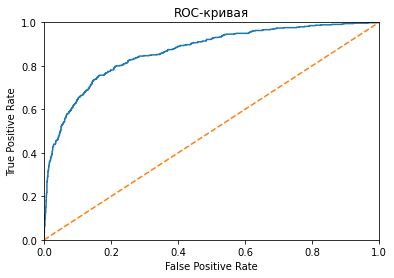

In [91]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()